In [35]:
import matplotlib.pyplot as plt
import numpy as np
from jax.config import config

# This makes sure we use double precision
config.update("jax_enable_x64", True)

import pymc as pm
import pytensor
import pandas as pd

# This is the most convenient function to run
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax

/tmp/ipykernel_61013/2669944641.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [5]:
# This is a good example model since it's built into PyMC
def fetch_radon_model():

    data = pd.read_csv(pm.get_data("radon.csv"))
    data["log_radon"] = data["log_radon"].astype(pytensor.config.floatX)
    county_names = data.county.unique()
    county_idx = data.county_code.values.astype("int32")

    n_counties = len(data.county.unique())

    with pm.Model() as hierarchical_model:
        # Hyperpriors for group nodes
        mu_a = pm.Normal("mu_a", mu=0.0, sigma=100.0)
        sigma_a = pm.HalfNormal("sigma_a", 5.0)
        mu_b = pm.Normal("mu_b", mu=0.0, sigma=100.0)
        sigma_b = pm.HalfNormal("sigma_b", 5.0)

        # Intercept for each county, distributed around group mean mu_a
        # Above we just set mu and sd to a fixed value while here we
        # plug in a common group distribution for all a and b (which are
        # vectors of length n_counties).
        a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
        # Intercept for each county, distributed around group mean mu_a
        b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

        # Model error
        eps = pm.HalfCauchy("eps", 5.0)

        radon_est = a[county_idx] + b[county_idx] * data.floor.values

        # Data likelihood
        radon_like = pm.Normal(
            "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon
        )

    return hierarchical_model

In [6]:
# Define your PyMC model as usual:
# Here we could use any PyMC model instead!
m = fetch_radon_model()

In [7]:
# Fit with DADVI using 30 fixed draws.
model_result = fit_pymc_dadvi_with_jax(m, num_fixed_draws=30)

/home/rgiordan/bin/miniforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'f': 2574.5587494379197, ||grad(f)||: 1139.4837990047079
'f': 2387.1172831167487, ||grad(f)||: 293.9666212183309
'f': 2223.0661300299853, ||grad(f)||: 153.62154118104695
'f': 2057.674973592278, ||grad(f)||: 654.0221164615175
'f': 1979.135609745822, ||grad(f)||: 143.39684397605322
'f': 5411.9324645173365, ||grad(f)||: 45687.85945624726
'f': 1897.3348769337608, ||grad(f)||: 125.58178876125993
'f': 1859.9509751175528, ||grad(f)||: 890.4212785329563
'f': 1796.7106422123345, ||grad(f)||: 166.50557550394046
'f': 1720.7314314182627, ||grad(f)||: 273.47923542163096
'f': 1674.907236301958, ||grad(f)||: 132.3404715835358
'f': 1504.3712336998108, ||grad(f)||: 158.39420702607242
'f': 1464.212233382474, ||grad(f)||: 81.96901477571173
'f': 211598.09791570745, ||grad(f)||: 442676.59589507355
'f': 1482.4283081797528, ||grad(f)||: 309.47793941040135
'f': 1445.9770241417273, ||grad(f)||: 61.270891267188645
'f': 1419.9593699356121, ||grad(f)||: 78.70770977586206
'f': 1412.3711035477993, ||grad(f)||: 29.4

In [33]:
# If we do this, we get draws from the mean field estimate
mean_field_draws = model_result.get_posterior_draws_mean_field()

# We could also look at the mean field means and standard deviations
mf_means = model_result.get_posterior_means()
mf_sds = model_result.get_posterior_standard_deviations_mean_field()

# All three are formatted the same way:
print(mean_field_draws.keys(), '\n')
print(mean_field_draws['b'].shape, '\n')

print(mf_means.keys(), '\n')
print(mf_sds.keys(), '\n')
print(mf_means['b'].shape, '\n')

dict_keys(['a', 'b', 'eps_log__', 'mu_a', 'mu_b', 'sigma_a_log__', 'sigma_b_log__']) 

(1000, 85) 

dict_keys(['a', 'b', 'eps_log__', 'mu_a', 'mu_b', 'sigma_a_log__', 'sigma_b_log__']) 

dict_keys(['a', 'b', 'eps_log__', 'mu_a', 'mu_b', 'sigma_a_log__', 'sigma_b_log__']) 

(85,) 



Text(0.5, 0, 'Mean of posterior draws')

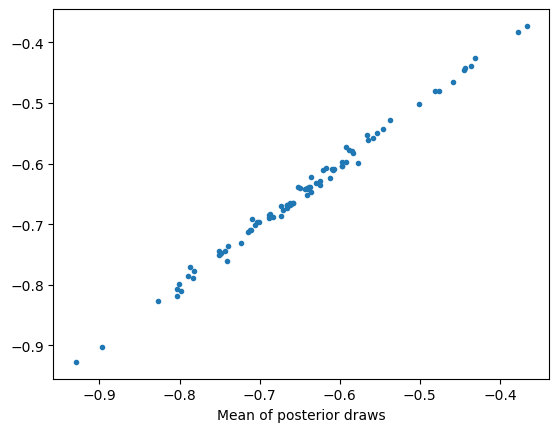

In [43]:
# The posterior draws differ from the MF optimum only by sampling error.  The advantage
# of the draws is in computing expectations of nonlinear functions of the parameters.
plt.plot(mf_means['b'], np.mean(mean_field_draws['b'], axis=0), '.')
plt.xlabel('Mean field posterior mean')
plt.xlabel('Mean of posterior draws')

# LRVB correction

- `lrvb_sd` is the LRVB estimate of the posterior SD
- `freq_sd` is the LRVB estimate of the SD due to the fixed draws
- `n_hvp_calls` is the number of hvp calls that were required to compute this

In [52]:
# Here we use the identity function, but something else works too via the delta method.
# This also computes the frequentist SD estimate.
lrvb_corrected = model_result.get_frequentist_sd_and_lrvb_correction_of_scalar_valued_function(lambda x: x['b'][0])
print(lrvb_corrected.keys())

dict_keys(['mean', 'lrvb_sd', 'freq_sd', 'n_hvp_calls'])


In [51]:
print(f'LR sd =\t{lrvb_corrected["lrvb_sd"]}')
print(f'MF sd =\t{mf_sds["b"][0]}')

LR sd =	0.2643477673062741
MF sd =	0.24134678793777933


In [58]:
lr_draws = np.random.normal(loc=lrvb_corrected['mean'], scale=lrvb_corrected['lrvb_sd'], size=(1000, ))

# Run the same model with PyMC NUTS

In [11]:
with m as model:
    nuts_res = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [20]:
# Flatten NUTS into a vector
example_variable = nuts_res.posterior['b'].values
num_chains, num_draws, _ = example_variable.shape
reshaped = example_variable.reshape(num_chains * num_draws, -1)

## Compare NUTS with mean field and linear response

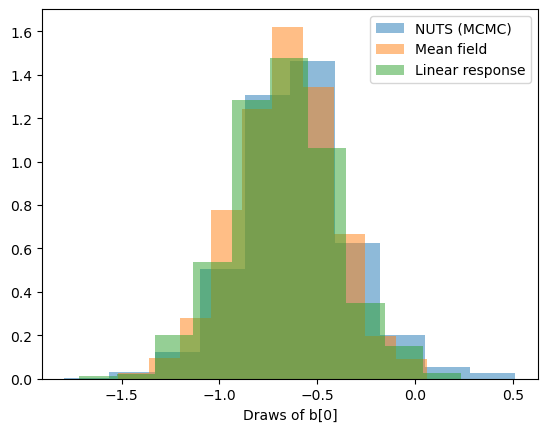

In [59]:
# Compare against mean field
plt.hist(reshaped[:, 0], density=True, alpha=0.5, label='NUTS (MCMC)')
plt.hist(mean_field_draws['b'][:, 0], density=True, alpha=0.5, label='Mean field')
plt.hist(lr_draws, density=True, alpha=0.5, label='Linear response')
plt.xlabel('Draws of b[0]')
plt.legend()